In [1]:
# Convolution Neural Network
# Src for dataset:
# https://www.mvtec.com/company/research/datasets/mvtec-ad
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_curve, auc, f1_score, roc_auc_score, precision_recall_curve,  \
    accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
import shutil
import sys
from distutils.dir_util import copy_tree

# Directory setup
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
print(nb_dir)

/Users/hakonsandaker/MEGA/Studier/H20/Machine Learning/Last project


# Copy images to right place

In [2]:
TYPE = 'toothbrush'
CASE_FOLDER = "case_folder_2"

while os.path.exists(CASE_FOLDER):
    CASE_FOLDER += "_1"

if not os.path.exists(CASE_FOLDER):
    os.makedirs(CASE_FOLDER)

# Copy samples
copy_tree(TYPE + '/train/good', CASE_FOLDER + '/test/good')
copy_tree(TYPE + '/test/defective', CASE_FOLDER + '/test/defective')
copy_tree(TYPE + '/test/good', CASE_FOLDER + '/train/good')

['case_folder_2_1_1_1_1_1_1_1_1/train/good/002.png',
 'case_folder_2_1_1_1_1_1_1_1_1/train/good/003.png',
 'case_folder_2_1_1_1_1_1_1_1_1/train/good/001.png',
 'case_folder_2_1_1_1_1_1_1_1_1/train/good/000.png',
 'case_folder_2_1_1_1_1_1_1_1_1/train/good/010.png',
 'case_folder_2_1_1_1_1_1_1_1_1/train/good/004.png',
 'case_folder_2_1_1_1_1_1_1_1_1/train/good/005.png',
 'case_folder_2_1_1_1_1_1_1_1_1/train/good/011.png',
 'case_folder_2_1_1_1_1_1_1_1_1/train/good/007.png',
 'case_folder_2_1_1_1_1_1_1_1_1/train/good/006.png',
 'case_folder_2_1_1_1_1_1_1_1_1/train/good/008.png',
 'case_folder_2_1_1_1_1_1_1_1_1/train/good/009.png']

# Import the images

In [3]:
IMAGE_SIZE = 256

TRAIN_DIR = CASE_FOLDER + '/train'
VALID_DIR = CASE_FOLDER + '/test'

train_datagen = ImageDataGenerator(rescale = 1/(255))
validation_datagen = ImageDataGenerator(rescale = 1/(255))

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    classes = ['defective', 'good'],
    target_size= (IMAGE_SIZE, IMAGE_SIZE),  # All images will be resized to 512x512
    batch_size= 120,
    class_mode='binary')
print("Train done...")

validation_generator = validation_datagen.flow_from_directory(
    VALID_DIR,
    classes = ['defective', 'good'],
    target_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size= 4,
    class_mode= 'binary',
    shuffle= False)
print("Vailidation done...")

Found 12 images belonging to 2 classes.
Train done...
Found 90 images belonging to 2 classes.
Vailidation done...


# CNN

In [4]:
tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
tf.keras.layers.MaxPooling2D(2, 2)

In [5]:

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 512x512 with 3 bytes color
    # 1st convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # 2nd convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # 3rd convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # 4th convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # 5th convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(IMAGE_SIZE, activation='relu'),
    # Only 1 output neuron. 
    # It will contain a value from 0-1 where 0 for 1 class ('dandelions') and 1 for the other ('grass')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [6]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr=0.001), metrics=['accuracy'])

In [7]:
history = model.fit(train_generator, steps_per_epoch=40, 
    epochs=15, verbose=1, validation_data=validation_generator, validation_steps=100)

model.evaluate(validation_generator)

validation_generator.reset()

preds = model.predict(x=validation_generator, verbose=1)
y_pred = preds.argmax(axis=1)

Train for 40 steps, validate for 100 steps
Epoch 1/15
23/23 [==============================] - 5s 196ms/step


In [8]:
fpr, tpr, _thresholds = roc_curve(validation_generator.classes, preds)
roc_auc = auc(fpr, tpr)

print(">>>> Confusion matrix")
print(confusion_matrix(validation_generator.classes, y_pred))

print(">>>> Accuracy %.2f" % accuracy_score(validation_generator.classes, y_pred))
print(">>>> Precision %.2f" % precision_score(validation_generator.classes, y_pred, average='macro'))
print(">>>> Recall %.2f" % recall_score(validation_generator.classes, y_pred, average='macro'))
print(">>>> F1_score %.2f" % f1_score(validation_generator.classes, y_pred, average='macro'))
print('>>>> ROC AUC: %0.2f' % roc_auc)

>>>> Confusion matrix
[[30  0]
 [60  0]]
>>>> Accuracy 0.33
>>>> Precision 0.17
>>>> Recall 0.50
>>>> F1_score 0.25
>>>> ROC AUC: 0.60


/Users/hakonsandaker/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


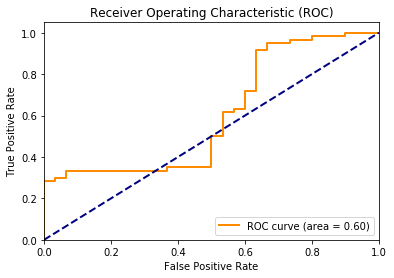

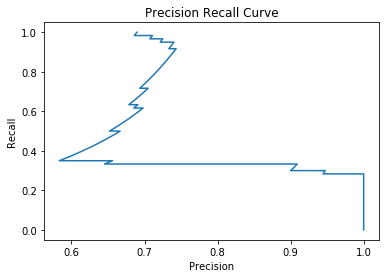

In [9]:
# Plot the ROC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Plot the Precision / Recall
plt.figure()
precision, recall, _ = precision_recall_curve(validation_generator.classes, preds)
plt.plot(precision, recall)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision Recall Curve')
plt.show()